# はじめに

機械学習のための連続最適化という本を買った．
今回はこの本の制約付き最適化，特に主問題に対する最適化法である
なんとかかんとかとなんとかかんとかTODOを実装する．

Canonical Correlation Analysis (正準相関分析)をpytorchを使って実装する．



In [1]:
import pylab as plt
import numpy as np
import torch 
from torch.autograd import Variable
import logging
import coloredlogs
from tqdm import tqdm

logger = logging.getLogger(__name__)
coloredlogs.install()

%matplotlib inline

In [2]:
logger.setLevel("DEBUG")
if logger.level > logging.WARNING:
    tqdm = lambda x:x

# データの準備

In [3]:
u1 = np.r_[np.zeros(40), np.ones(30), np.ones(50)*2, np.ones(30), np.zeros(20), np.ones(30) ]
u2 = np.r_[np.ones(25), np.zeros(25), np.ones(25)*2, np.ones(55), np.zeros(35), np.ones(35) ]
u = np.c_[u1, u2]

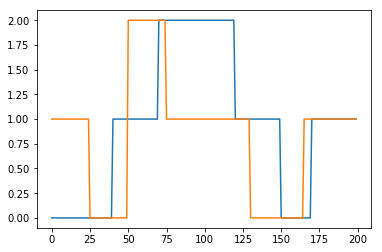

In [4]:
plt.plot(u)

In [5]:
sx = np.random.random(len(u)) * 10
sy = np.random.random(len(u)) * 10
sd = np.random.random(len(u)) * 10

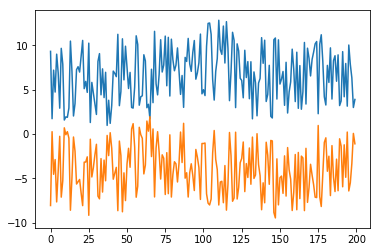

In [6]:
x = np.c_[
    u1 + sx + np.random.random(len(u)),
    u2 - sx + np.random.random(len(u)),   
]
plt.plot(x)

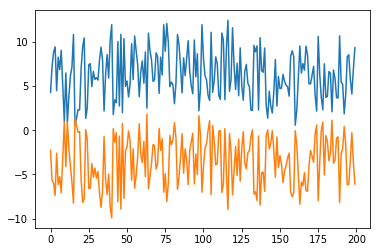

In [7]:
y = np.c_[
    u1 + sy + np.random.random(len(u)),
    u2 - sy + np.random.random(len(u)),   
]
plt.plot(y)

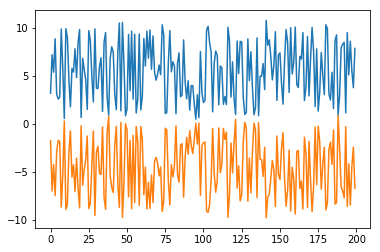

In [8]:
dummy = np.c_[
    sd + np.random.random(len(u)),
    -sd + np.random.random(len(u)),   
]
plt.plot(dummy)

# Scikit-Learnによる実装

In [9]:
from sklearn.cross_decomposition import CCA

In [10]:
cca = CCA(n_components=1)

0.881460530944


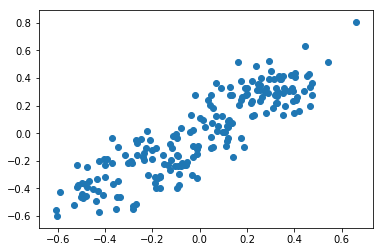

In [11]:
t_x, t_y = cca.fit_transform(x,y)
plt.scatter(t_x, t_y)
print(np.corrcoef(t_x.T, t_y.T )[0,1])

0.48525881695


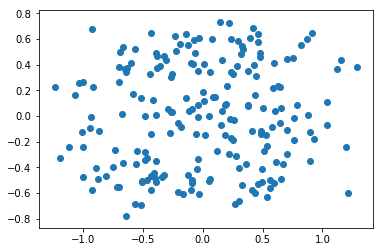

In [12]:
t_x, t_d = cca.fit_transform(x,dummy)
plt.scatter(t_x, t_d)
print(np.corrcoef(t_x.T, t_y.T )[0,1])

# PyTorchによる実装

In [13]:
x -= np.mean(x, axis=0)
y -= np.mean(y, axis=0)
dummy -= np.mean(dummy, axis=0)
N = len(x)

def CCA(x,y,
        nb_steps = 100000,
        lr = 0.001,
        γ = 0.5):
    vxx = np.dot(x.transpose(), x)/N
    vyy = np.dot(y.transpose(), y)/N
    vxy = np.dot(x.transpose(), y)/N
    
    X = Variable(torch.from_numpy(x)).float()
    Y = Variable(torch.from_numpy(y)).float()
    
    a = Variable(torch.randn(2,1), requires_grad=True)
    b = Variable(torch.randn(2,1), requires_grad=True)
    
    Vxx = Variable(torch.from_numpy(vxx)).float()
    Vyy = Variable(torch.from_numpy(vyy)).float()
    Vxy = Variable(torch.from_numpy(vxy)).float()
    
    hist = []
    from torch import optim
    optimizer = optim.Adam([a, b], lr = 0.0001)

    for i in tqdm(range(nb_steps)):
        Loss = - torch.mm(torch.mm(torch.t(a), Vxy), b)  \
             + γ * torch.abs(1 - torch.mm(torch.mm(torch.t(a),Vxx),a))  \
             + γ * torch.abs(1 - torch.mm(torch.mm(torch.t(b),Vyy),b)) 
        hist.append(Loss.data.numpy()[0,0])
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()
        
    x_t = np.dot(a.data.numpy().transpose(), x.transpose())
    y_t = np.dot(b.data.numpy().transpose(), y.transpose())
    cca_score = torch.mm(torch.mm(torch.t(a), Vxy), b)
    
    logger.debug(torch.mm(torch.mm(torch.t(b),Vyy),b).data.numpy())
    logger.debug(torch.mm(torch.mm(torch.t(a),Vxx),a).data.numpy())
    return hist, x_t, y_t, cca_score

In [14]:
hist, x_t, y_t, cca_score = CCA(x,y)

100%|██████████| 100000/100000 [00:21<00:00, 4665.26it/s]


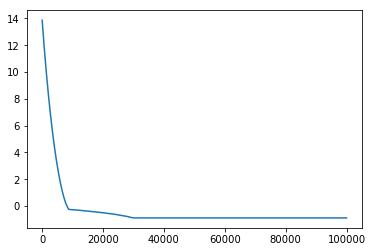

In [15]:
plt.plot(hist)

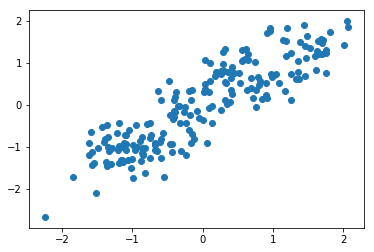

In [16]:
plt.scatter(x_t, y_t)

In [17]:
cca_score

Variable containing:
 0.8816
[torch.FloatTensor of size 1x1]

100%|██████████| 100000/100000 [00:21<00:00, 4711.80it/s]


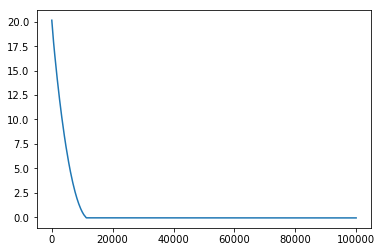

In [18]:
hist, x_t, y_t, cca_score = CCA(x,dummy)
plt.plot(hist)

Variable containing:
1.00000e-02 *
  7.3709
[torch.FloatTensor of size 1x1]

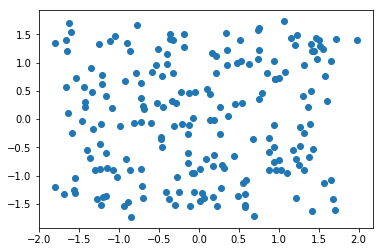

In [19]:
plt.scatter(x_t, y_t)
cca_score